<a href="https://colab.research.google.com/github/spirosdouk/hy485-/blob/main/485%5B2025%5D_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SVM Classification – Breast Cancer Dataset
In this exercise, you'll explore Support Vector Machines (SVMs) for binary classification using the Breast Cancer Wisconsin dataset. You'll go beyond just training a model — you'll investigate how SVMs make decisions, visualize decision boundaries, compare kernels, tune hyperparameters, and evaluate model confidence.

## Import necessary libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


##Load & Explore the Breast Cancer Dataset

Use the built-in breast cancer dataset and get the basic characteristics for the data.

In [6]:
data = load_breast_cancer()

# Explore basic characteristics of the dataset
print("Dataset Keys:", data.keys())
print("Data Shape:", data.data.shape)              # (n_samples, n_features)
print("Feature Names:", data.feature_names)
print("Target Names:", data.target_names)

# Convert the dataset into a Pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Display the first 5 rows
print(df.head())

# Get basic summary statistics
print(df.describe())

Dataset Keys: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Data Shape: (569, 30)
Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target Names: ['malignant' 'benign']
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69       

**Question:** What kind of classification problem is this? Are the classes balanced?

## Preprocess the Data
Standardize the features and split the data.

In [7]:
# Separate features and target
X = data.data
y = data.target

# Split the data into training and testing sets (80/20 split, stratified by target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optionally, print shapes to confirm correct splitting and scaling
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)


Training set shape: (455, 30)
Testing set shape: (114, 30)


## Visualize with PCA (2D)

Use PCA to reduce the feature space to 2D and plot the points.

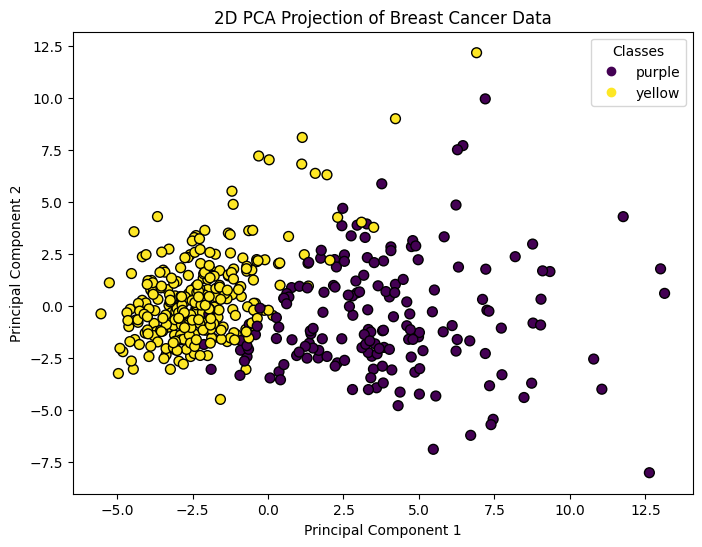

In [12]:
# Apply PCA to reduce dimensions to 2 components from the scaled training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Create a scatter plot of the two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', s=50, edgecolor='k')

# Add labels and title for clarity
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection of Breast Cancer Data')

# Add a legend mapping color to target class
# Since target 0 corresponds to 'malignant' and 1 corresponds to 'benign':
handles, _ = scatter.legend_elements()
plt.legend(handles, ['purple', 'yellow'], title="Classes")

plt.show()


**Question:** Can the classes be separated linearly in this reduced space?

**Answer:** While we do see two somewhat distinct clusters, there is visible overlap between the malignant (purple) and benign (yellow) points in this 2D projection. This overlap suggests that a single straight line (linear boundary) would not cleanly separate the two classes in the reduced PCA space without misclassifying some points.

## Train & Evaluate a Linear SVM

Train an SVM with a linear kernel and evaluate its performance.

In [11]:
# Initialize the linear SVM classifier. The 'C' parameter controls the trade-off between margin width and classification error.
linear_svm = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model with the scaled training data
linear_svm.fit(X_train_scaled, y_train)

# Predict the labels on the test set
y_pred = linear_svm.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

# Detailed classification report: includes precision, recall, f1-score for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['malignant', 'benign']))

# Confusion Matrix to get a direct view of the classification errors
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.9736842105263158

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.98      0.96        42
      benign       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
[[41  1]
 [ 2 70]]


## Visualize Decision Boundary (with PCA Projection)

Project the decision surface into PCA space (from previous task).


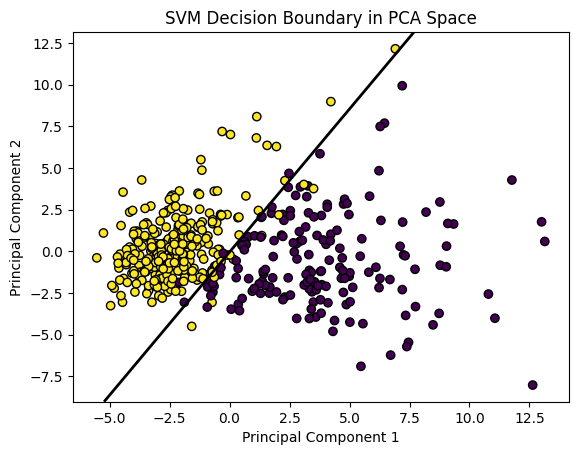

In [15]:
# Define a grid in the PCA space
x_min, x_max = X_pca[:, 0].min()-1, X_pca[:, 0].max()+1
y_min, y_max = X_pca[:, 1].min()-1, X_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Inverse transform the grid points to the original (scaled) space
grid = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(grid)

# Evaluate the decision function for each grid point
Z = linear_svm.decision_function(grid_original)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary in PCA Space")
plt.show()


## Train an SVM with RBF Kernel

Use a radial basis function kernel and compare its performance.

In [16]:
# Train SVM with RBF kernel
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)

# Predict the labels on the test set using the RBF kernel
y_pred_rbf = rbf_svm.predict(X_test_scaled)

# Evaluate performance using accuracy, classification report, and confusion matrix
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("RBF Kernel SVM Accuracy Score:", accuracy_rbf)

print("\nRBF Kernel SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf, target_names=['malignant', 'benign']))

print("RBF Kernel SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rbf))


RBF Kernel SVM Accuracy Score: 0.9824561403508771

RBF Kernel SVM Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

RBF Kernel SVM Confusion Matrix:
[[41  1]
 [ 1 71]]


## Cross-Validation Comparison

Compare linear vs. RBF kernel using 5-fold cross-validation.

In [17]:
from sklearn.model_selection import cross_val_score

# Initialize the classifiers with the same parameters as before
linear_svm = SVC(kernel='linear', C=1.0, random_state=42)
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Perform 5-fold cross-validation for each model on the scaled training data
cv_scores_linear = cross_val_score(linear_svm, X_train_scaled, y_train, cv=5)
cv_scores_rbf = cross_val_score(rbf_svm, X_train_scaled, y_train, cv=5)

# Print the individual fold scores and mean score for each classifier
print("Linear SVM Cross-Validation Scores:", cv_scores_linear)
print("Linear SVM Mean CV Score:", cv_scores_linear.mean())

print("RBF SVM Cross-Validation Scores:", cv_scores_rbf)
print("RBF SVM Mean CV Score:", cv_scores_rbf.mean())


Linear SVM Cross-Validation Scores: [0.95604396 0.95604396 0.95604396 0.98901099 0.97802198]
Linear SVM Mean CV Score: 0.9670329670329669
RBF SVM Cross-Validation Scores: [0.95604396 0.98901099 0.94505495 0.97802198 0.98901099]
RBF SVM Mean CV Score: 0.9714285714285715


## Grid Search Hyperparameter Tuning (RBF)
Perform a grid search over `C` and `gamma` for the RBF kernel.

In [19]:
from sklearn.model_selection import GridSearchCV

# Define a grid of parameter values
param_grid = {
    'C': [0.1, 1, 10, 100],      # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient
}

# Initialize the RBF SVM (no need to specify C or gamma here)
rbf_svm = SVC(kernel='rbf', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rbf_svm,
                           param_grid=param_grid,
                           cv=5,                # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1)           # Use all available cores

# Fit the grid search on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.01}
Best Cross-Validation Score: 0.9802197802197803


## Evaluate Model Confidence (Decision Function)

Plot the decision function (histogram) or prediction confidence on the PCA plot.


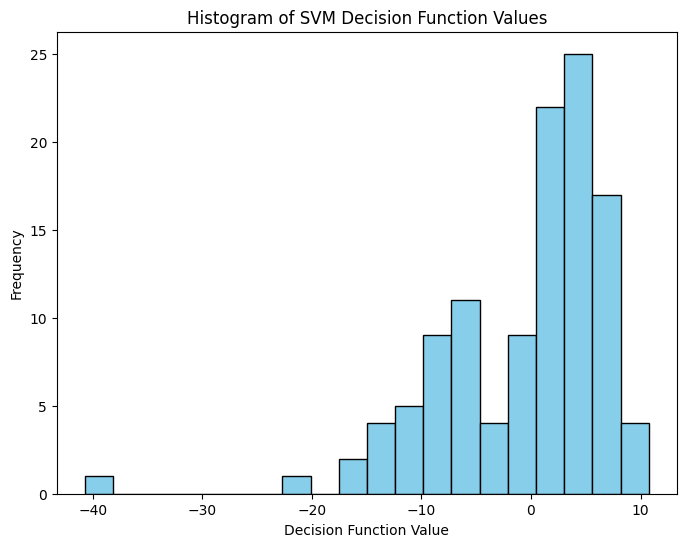

In [26]:
# Fit the linear SVM on the scaled training data (if not already fitted)
linear_svm.fit(X_train_scaled, y_train)

# Now evaluate the decision function on the scaled test set
decision_values = linear_svm.decision_function(X_test_scaled)

# Option 1: Plot a histogram of decision function values
plt.figure(figsize=(8, 6))
plt.hist(decision_values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Decision Function Value')
plt.ylabel('Frequency')
plt.title('Histogram of SVM Decision Function Values')
plt.show()

**Question:** Are predictions well-separated or clustered near the margin?


**Answear:** Looking at the histogram of SVM decision function values, I can see that the predictions are not well-separated but instead show significant clustering near the margin.

This distribution shows that most predictions fall relatively close to the decision boundary (which would be at value 0), particularly with the high frequency of samples in the 0 to +10 range. This clustering near the margin suggests that the SVM is making many predictions with moderate confidence rather than with strong separation between classes.